In [1]:
import sys

import numpy as np

from matplotlib import pyplot as plt, colors, cm, scale as mscale
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple


from tqdm import tqdm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, BasicEquivalence

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}\usepackage{xcolor}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.title_fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
shape_cycle = ['o', 'v', '*']

In [3]:
def sample_mp(gamma, min_qp=2000):
    
    if gamma > 1:
        q = min_qp
        p = int(gamma * q)
        X = np.random.randn(q, p)
        return np.concatenate([np.linalg.eigvalsh(X @ X.T / q), np.zeros(p - q)])
    else:
        p = min_qp
        q = int(p / gamma)
        X = np.random.randn(q, p)
        return np.linalg.eigvalsh(X.T @ X / q)

gammas = np.asarray([0.2, 0.9, 5])
n_ps = np.linspace(0.1, 2, 2000)
n_ps_empirical = np.linspace(0.1, 2, 31)

z0s = np.zeros((len(gammas), len(n_ps)))
empirical = np.zeros((len(gammas), len(n_ps_empirical)))

p = 500

for k, gamma in enumerate(gammas):
    
    spectrum = DiscreteSpectrum(sample_mp(gamma))
        
    q = int(p / gamma)
    Y = np.random.randn(q, p) / np.sqrt(q)
    
    for j, n_p in enumerate(n_ps):
        z0s[k, j] = BasicEquivalence(spectrum, 1 / n_p).z_0
        
    for j, n_p in enumerate(tqdm(n_ps_empirical)):
        n = int(p * n_p)
        X = np.random.randn(n, p) / np.sqrt(n)
        XY = X @ Y.T
        evs = np.linalg.eigvalsh(XY.T @ XY)
        empirical[k, j] = evs[-min(n, q, p)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 132.57it/s]


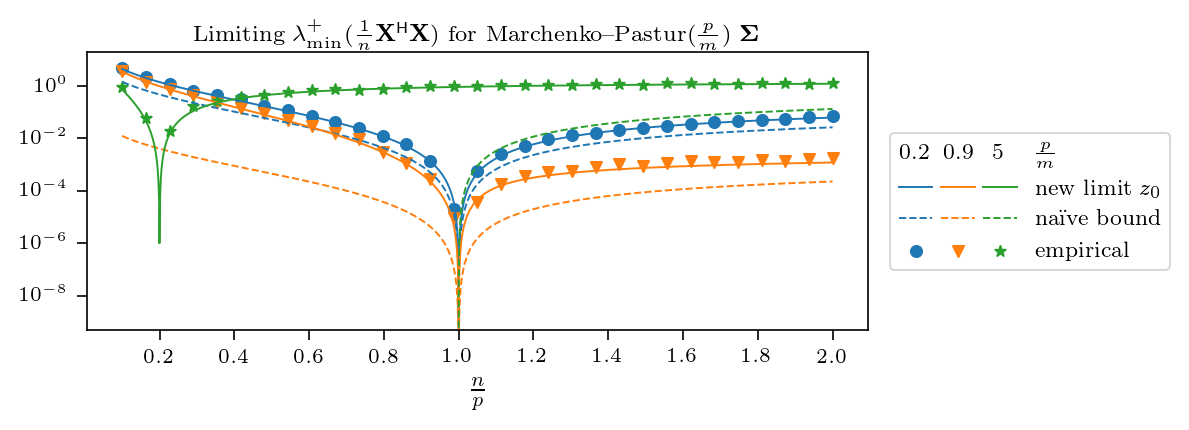

In [4]:
fig, ax = plt.subplots(figsize=(6.5, 2.25), dpi=200)

gamma_strs = [r'$\tfrac{1}{5}$', r'$\tfrac{19}{20}$', '$5$']
gamma_strs = [f'${gamma:g}$' for gamma in gammas]

z0_plts = []
naive_plts = []
emp_plts = []

for k, gamma in enumerate(gammas):
    mp_str = f'MP({gamma_strs[k]})'
    
    z0_plt, = ax.plot(n_ps, z0s[k, :], '-', color=color_cycle[k], label=f'{mp_str}, new limit $z_0$')
    naive_plt, = ax.plot(n_ps, (1 - np.sqrt(gamma)) ** 2 * (1 - np.sqrt(1 / n_ps)) ** 2 * (np.minimum(gamma, 1 / n_ps) < 1), '--', color=color_cycle[k], label=f'{mp_str}, na\\"ive bound')
    emp_plt = ax.scatter(n_ps_empirical, empirical[k, :], marker=shape_cycle[k], color=color_cycle[k], label=f'{mp_str}, empirical')
    
    z0_plts.append(z0_plt)
    naive_plts.append(naive_plt)
    emp_plts.append(emp_plt)

plt.title(r'Limiting $\lambda_{\min}^+(\tfrac{1}{n} \mathbf{X}^\mathsf{H} \mathbf{X})$ for Marchenko--Pastur($\tfrac{p}{m}$) $\bm{\Sigma}$', pad=4)
plt.yscale('log')
plt.xticks(np.linspace(0.2, 2, 10))
plt.xlabel(r'$\tfrac{n}{p}$')
plt.ylim(5e-10, None)
ax.legend(
    [tuple(z0_plts), tuple(naive_plts), tuple(emp_plts)], 
    ['new limit $z_0$', 'na\\"ive bound', 'empirical'], 
    handler_map={tuple: HandlerTuple(ndivide=None)},
    numpoints=1, handlelength=5.3,
    title=r'$0.2\hspace{5.1pt}0.9\hspace{7pt}5\hspace{10.5pt}\tfrac{p}{m}$', alignment='left',
    bbox_to_anchor=(1.4, 0.75)
)

plt.tight_layout()
plt.savefig('lambda_minnz_bound.pdf', bbox_inches='tight')
plt.show()